In [1]:
import sys
sys.path.append("..")
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras, keras.layers as L, keras.backend as K
import numpy as np
from sklearn.model_selection import train_test_split

%matplotlib inline
import matplotlib.pyplot as plt
import keras
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers   import Adam
#from utils.callbacks import all_callbacks
from keras.callbacks import EarlyStopping, ReduceLROnPlateau



import numpy as np
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

dataset_folder = 'normalized_images'

image_names = os.listdir(dataset_folder)

X = []

for image_name in image_names:
    if image_name == '.ipynb_checkpoints':
        continue

    img = cv2.imread(os.path.join(dataset_folder, image_name), 0)
    #img = cv2.resize(img, (720, 720))

    # 垂直翻转
    img_vflip = cv2.flip(img, 0)

    # 水平翻转
    img_hflip = cv2.flip(img, 1)

    # 15度旋转
    rows, cols = img.shape
    M_rot = cv2.getRotationMatrix2D((cols/2, rows/2), 90, 1)
    img_rot = cv2.warpAffine(img, M_rot, (cols, rows))

    # 15度剪切
  #  M_shear = np.array([[1, np.tan(np.deg2rad(15)), 0], [0, 1, 0]], dtype=float)
  #  img_shear = cv2.warpAffine(img, M_shear, (cols, rows))

    for augmented_img in [img, img_vflip, img_hflip, img_rot]:
        augmented_img = augmented_img[..., np.newaxis]
        X.append(augmented_img)

X = np.array(X)
IMG_SHAPE = X.shape[1:]
print(IMG_SHAPE)

X = X.astype('float32') / 255.0 - 0.5
X_train, X_test = train_test_split(X, test_size=0.1, shuffle=True, random_state=42)
print(X_test.shape)

(48, 48, 1)
(231, 48, 48, 1)


In [3]:
from keras.models import load_model
autoencoder = load_model('autoencoder.h5')
encoder = load_model('encoder.h5')
decoder = load_model('decoder.h5')


X shape: (2304, 48, 48, 1)


9

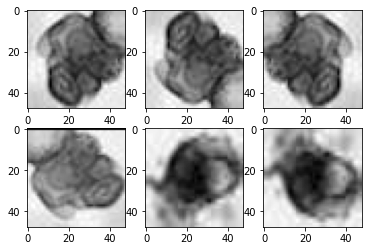

In [3]:
def show_image(x):
    #plt.imshow(np.clip(x + 0.5, 0, 1))
    plt.imshow(x, cmap='gray')
    
plt.title('sample images')

for i in range(6):
    plt.subplot(2,3,i+1)
    show_image(X[i])

print("X shape:", X.shape)



del X
import gc
gc.collect()

In [4]:
def visualize(img,encoder,decoder):
    """Draws original, encoded and decoded images"""
    code = encoder.predict(img[None])[0]  # img[None] is the same as img[np.newaxis, :]
    reco = decoder.predict(code[None])[0]

    plt.subplot(1,3,1)
    plt.title("Original")
    show_image(img)

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([code.shape[-1]//2,-1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    show_image(reco)
    plt.show()

In [10]:
def build_conv_autoencoder(img_shape, code_size):
    # Encoder
    encoder = keras.models.Sequential()
    encoder.add(L.InputLayer(img_shape))
    encoder.add(L.Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu'))
    encoder.add(L.Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu'))
    encoder.add(L.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
    encoder.add(L.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
    #encoder.add(L.Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
   # encoder.add(L.Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'))
    encoder.add(Dropout(0.5))
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    
    encoder.add(L.Flatten())
    encoder.add(L.Dense(code_size))  

    # Decoder
    decoder = keras.models.Sequential()
    decoder.add(L.InputLayer((code_size,)))
    decoder.add(L.Dense(24 * 24 * 32)) 
    decoder.add(L.Reshape((24, 24, 32)))
    print(encoder.layers[-3].output_shape)
   # decoder.add(L.Conv2DTranspose(512, kernel_size=(3, 3), padding='same', activation='relu'))
   # decoder.add(L.Conv2DTranspose(256, kernel_size=(3, 3), padding='same', activation='relu'))
    decoder.add(L.Conv2DTranspose(32, kernel_size=(3, 3), padding='same', activation='relu'))
    decoder.add(L.Conv2DTranspose(32, kernel_size=(3, 3), padding='same', activation='relu'))
    decoder.add(L.Conv2DTranspose(16, kernel_size=(3, 3), padding='same', activation='relu'))
    decoder.add(L.Conv2DTranspose(16, kernel_size=(3, 3), padding='same', activation='relu'))
    decoder.add(Dropout(0.5))
    decoder.add(L.UpSampling2D((2, 2)))
    

    decoder.add(L.Conv2DTranspose(img_shape[-1], kernel_size=(3, 3), padding='same')) 

    return encoder, decoder


In [9]:
from keras import regularizers

def build_conv_autoencoder(img_shape, code_size):
    l1_reg_strength = 10e-5
    l2_reg = regularizers.l1(l1_reg_strength)
    # Encoder
    encoder = keras.models.Sequential()
    encoder.add(L.InputLayer(img_shape))
    encoder.add(L.Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=l2_reg)) 
    encoder.add(L.Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=l2_reg)) 
    #encoder.add(Dropout(0.5))
    encoder.add(L.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=l2_reg)) 
    encoder.add(L.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=l2_reg)) 
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    #encoder.add(Dropout(0.5))
    ''''
    encoder.add(L.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=l2_reg))
    encoder.add(L.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=l2_reg))
    encoder.add(L.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=l2_reg))
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))

    encoder.add(L.Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=l2_reg))
    encoder.add(L.Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=l2_reg))
    encoder.add(L.Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=l2_reg))
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    '''
    #encoder.add(Dropout(0.5))
    encoder.add(L.Flatten())
    encoder.add(L.Dense(code_size))  

    # Decoder
    decoder = keras.models.Sequential()
    decoder.add(L.InputLayer((code_size,))) 
    decoder.add(L.Dense(24*24*32, kernel_regularizer=l2_reg)) 
    decoder.add(L.Reshape((24, 24, 32)))
    print(encoder.layers[-3].output_shape)
    decoder.add(L.Conv2DTranspose(32, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=l2_reg))
    decoder.add(L.Conv2DTranspose(32, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=l2_reg))
    decoder.add(L.Conv2DTranspose(16, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=l2_reg))
    decoder.add(L.Conv2DTranspose(16, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=l2_reg))
    decoder.add(L.UpSampling2D((2, 2)))
    ''''
    decoder.add(L.Conv2DTranspose(64, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=l2_reg))
    decoder.add(L.Conv2DTranspose(64, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=l2_reg))
    #decoder.add(Dropout(0.5))
    decoder.add(L.Conv2DTranspose(64, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=l2_reg))
    decoder.add(L.UpSampling2D((2, 2)))
    #decoder.add(Dropout(0.5))

    decoder.add(L.Conv2DTranspose(16, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=l2_reg))
    decoder.add(L.Conv2DTranspose(16, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=l2_reg))
    decoder.add(L.Conv2DTranspose(16, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=l2_reg))
    decoder.add(L.UpSampling2D((2, 2)))
    #decoder.add(Dropout(0.5))
    '''
    decoder.add(L.Conv2DTranspose(img_shape[-1], kernel_size=(3, 3), padding='same', kernel_regularizer=l2_reg)) 

    return encoder, decoder


In [4]:
def build_conv_autoencoder(img_shape, code_size):
    # Encoder
    #print(img_shape)
    encoder = keras.models.Sequential()
    encoder.add(L.InputLayer(img_shape))
    encoder.add(L.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu')) 
    encoder.add(L.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu')) 
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    encoder.add(L.Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
    encoder.add(L.Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    encoder.add(L.Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
    encoder.add(L.Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))    
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    encoder.add(L.Flatten())
    encoder.add(L.Dense(code_size))  
    ''''
    print(encoder.layers[1].output_shape)
    print(encoder.layers[2].output_shape)
    print(encoder.layers[3].output_shape)
    print(encoder.layers[5].output_shape)
    print(encoder.layers[6].output_shape)
    print(encoder.layers[-3].output_shape)
    '''
    # Decoder
    decoder = keras.models.Sequential()
    decoder.add(L.InputLayer((code_size,)))
    decoder.add(L.Dense(24*24*32)) 
    decoder.add(L.Reshape((24, 24, 32)))
    print(encoder.layers[-3].output_shape)
    decoder.add(L.Conv2DTranspose(128, kernel_size=(3, 3), padding='same', activation='relu'))
    decoder.add(L.Conv2DTranspose(128, kernel_size=(3, 3), padding='same', activation='relu'))
    decoder.add(L.UpSampling2D((2, 2)))
    decoder.add(L.Conv2DTranspose(64, kernel_size=(3, 3), padding='same', activation='relu'))
    decoder.add(L.Conv2DTranspose(64, kernel_size=(3, 3), padding='same', activation='relu'))
    decoder.add(L.UpSampling2D((2, 2)))
    decoder.add(L.Conv2DTranspose(32, kernel_size=(3, 3), padding='same', activation='relu'))
    decoder.add(L.Conv2DTranspose(32, kernel_size=(3, 3), padding='same', activation='relu'))
    decoder.add(L.UpSampling2D((2, 2)))
    decoder.add(L.Conv2DTranspose(img_shape[-1], kernel_size=(3, 3), padding='same')) 

    return encoder, decoder


In [11]:
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dropout


encoder, decoder = build_conv_autoencoder(IMG_SHAPE, code_size=32)

inp = L.Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)
optimizer = optimizers.Adam(learning_rate=0.0001)
reduce_lr = ReduceLROnPlateau(factor=0.5,
                              patience=20,
                              min_delta=0.000001,  
                              cooldown=5,
                              min_lr=0.000001,
                              verbose=1)

# 加入与剪枝相关的回调
#update_pruning = pruning_callbacks.UpdatePruningStep()

callbacks_list = [reduce_lr]
autoencoder = keras.models.Model(inputs=inp, outputs=reconstruction)
autoencoder.compile(optimizer=optimizer, loss='mse')

autoencoder.fit(x=X_train, y=X_train, epochs=50,
                validation_data=[X_test, X_test],
                batch_size=16,
                callbacks=callbacks_list,
                verbose=1)


(None, 24, 24, 32)
Epoch 1/50
130/130 [==============================] - 6s 39ms/step - loss: 0.0436 - val_loss: 0.0342 - lr: 1.0000e-04
Epoch 2/50
130/130 [==============================] - 5s 38ms/step - loss: 0.0253 - val_loss: 0.0236 - lr: 1.0000e-04
Epoch 3/50
130/130 [==============================] - 5s 38ms/step - loss: 0.0180 - val_loss: 0.0192 - lr: 1.0000e-04
Epoch 4/50
130/130 [==============================] - 5s 38ms/step - loss: 0.0152 - val_loss: 0.0165 - lr: 1.0000e-04
Epoch 5/50
130/130 [==============================] - 5s 37ms/step - loss: 0.0131 - val_loss: 0.0155 - lr: 1.0000e-04
Epoch 6/50
130/130 [==============================] - 5s 38ms/step - loss: 0.0115 - val_loss: 0.0142 - lr: 1.0000e-04
Epoch 7/50
130/130 [==============================] - 5s 38ms/step - loss: 0.0106 - val_loss: 0.0131 - lr: 1.0000e-04
Epoch 8/50
130/130 [==============================] - 5s 38ms/step - loss: 0.0100 - val_loss: 0.0127 - lr: 1.0000e-04
Epoch 9/50
130/130 [=================

In [26]:

print(IMG_SHAPE)
encoder, decoder = build_conv_autoencoder(IMG_SHAPE, code_size=32)

inp = L.Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)
reduce_lr = ReduceLROnPlateau(factor=0.5,
                              patience=2,
                              min_delta=0.000001,  
                              cooldown=5,
                              min_lr=0.000001,
                              verbose=1)
callbacks_list = [reduce_lr]
autoencoder = keras.models.Model(inputs=inp, outputs=reconstruction)
autoencoder.compile(optimizer='adamax', loss='mse')

autoencoder.fit(x=X_train, y=X_train, epochs=50,
                validation_data=[X_test, X_test],
                callbacks=callbacks_list,
                verbose=1)


(48, 48, 1)
(None, 12, 12, 64)
Epoch 1/50
65/65 [==============================] - 10s 125ms/step - loss: 0.2882 - val_loss: 0.1331 - lr: 0.0010
Epoch 2/50
65/65 [==============================] - 8s 121ms/step - loss: 0.0942 - val_loss: 0.0672 - lr: 0.0010
Epoch 3/50
65/65 [==============================] - 8s 120ms/step - loss: 0.0581 - val_loss: 0.0474 - lr: 0.0010
Epoch 4/50
65/65 [==============================] - 8s 120ms/step - loss: 0.0435 - val_loss: 0.0393 - lr: 0.0010
Epoch 5/50
65/65 [==============================] - 8s 119ms/step - loss: 0.0370 - val_loss: 0.0338 - lr: 0.0010
Epoch 6/50
65/65 [==============================] - 8s 120ms/step - loss: 0.0326 - val_loss: 0.0303 - lr: 0.0010
Epoch 7/50
65/65 [==============================] - 8s 118ms/step - loss: 0.0298 - val_loss: 0.0281 - lr: 0.0010
Epoch 8/50
65/65 [==============================] - 8s 119ms/step - loss: 0.0276 - val_loss: 0.0258 - lr: 0.0010
Epoch 9/50
65/65 [==============================] - 8s 118ms/ste

8/8 [==============================] - 0s 27ms/step - loss: 0.0091
CNN MSE: 0.009053787216544151
1/1 [==============================] - 0s 121ms/step


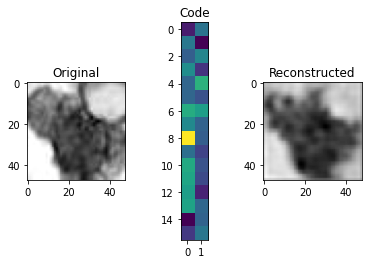

1/1 [==============================] - 0s 19ms/step


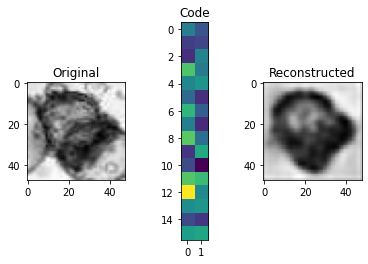

1/1 [==============================] - 0s 19ms/step


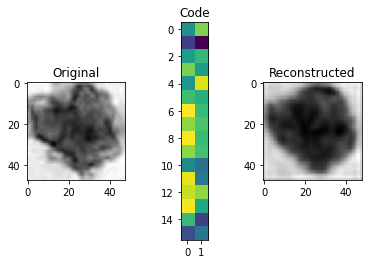

1/1 [==============================] - 0s 19ms/step


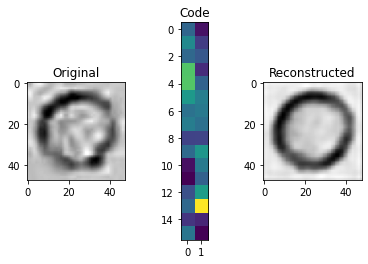

1/1 [==============================] - 0s 19ms/step


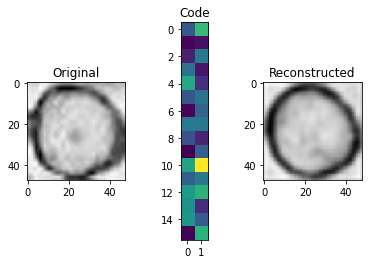

In [12]:
score = autoencoder.evaluate(X_test,X_test,verbose=1)
print("CNN MSE:", score)

for i in range(5):
    img = X_test[i]
    visualize(img,encoder,decoder)

In [74]:
autoencoder.save('autoencoder.h5')

# 保存编码器模型
encoder.save('encoder.h5')

# 保存解码器模型
decoder.save('decoder.h5')

65/65 [==============================] - 1s 16ms/step


/home/jupyter-qil420/.local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/jupyter-qil420/.local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/home/jupyter-qil420/.local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/jupyter-qil420/.local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


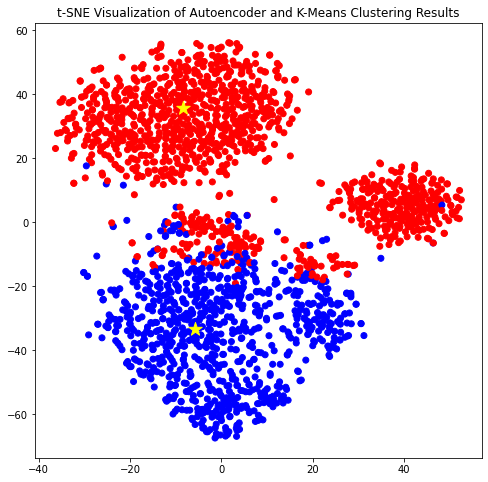

KMeans inertia: 5909.96337890625


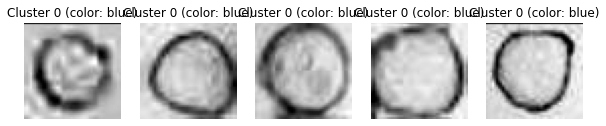

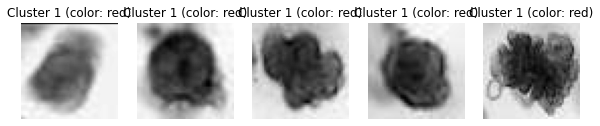

In [14]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np


codes_train = encoder.predict(X_train)


kmeans = KMeans(n_clusters=2)
clusters = kmeans.fit_predict(codes_train)


tsne = TSNE(n_components=2)
codes_2d = tsne.fit_transform(codes_train)

combined = np.vstack([codes_train, kmeans.cluster_centers_])
combined_2d = tsne.fit_transform(combined)

codes_2d = combined_2d[:-2]
cluster_centers_2d = combined_2d[-2:]

# 可视化
colors = ['blue', 'red']
point_colors = [colors[cluster] for cluster in clusters]

plt.figure(figsize=(8, 8))
plt.scatter(codes_2d[:, 0], codes_2d[:, 1], c=point_colors)
plt.scatter(cluster_centers_2d[:, 0], cluster_centers_2d[:, 1], marker='*', s=200, c='yellow')
plt.title('t-SNE Visualization of Autoencoder and K-Means Clustering Results')
plt.show()

print("KMeans inertia:", kmeans.inertia_)

n_clusters = 2  
n_images = 5  
n_columns = 5
n_rows = 1
for i in range(n_clusters):
    cluster_indices = np.where(clusters == i)[0]
    selected_indices = np.random.choice(cluster_indices, n_images)

    plt.figure(figsize=(n_columns * 2, n_rows * 2))
    for j, image_index in enumerate(selected_indices):
        image = X_train[image_index]
        plt.subplot(n_rows, n_columns, j + 1)
        plt.imshow(image, cmap='gray') 
        plt.axis('off')
        plt.title('Cluster {} (color: {})'.format(i, colors[i]))

    plt.show()


65/65 [==============================] - 2s 31ms/step


/home/jupyter-qil420/.local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/jupyter-qil420/.local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


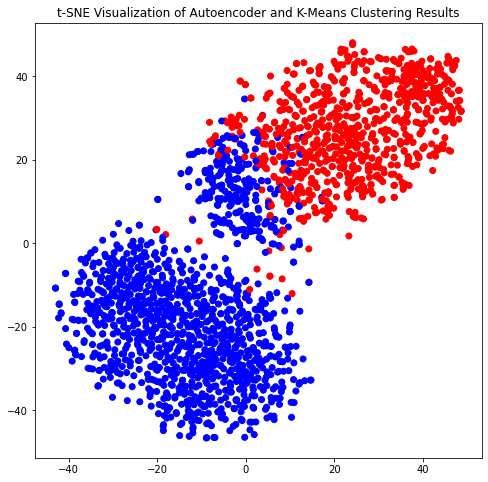

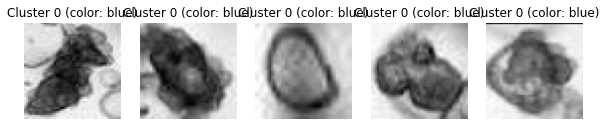

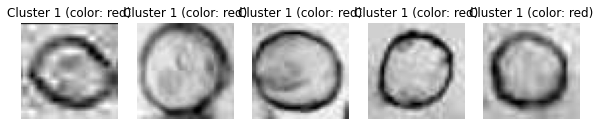

In [12]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import SpectralClustering



codes_train = encoder.predict(X_train)




kmeans = KMeans(n_clusters=2)
clusters = kmeans.fit_predict(codes_train)


tsne = TSNE(n_components=2)
codes_2d = tsne.fit_transform(codes_train)


colors = ['blue', 'red']


point_colors = [colors[cluster] for cluster in clusters]


plt.figure(figsize=(8, 8))
plt.scatter(codes_2d[:, 0], codes_2d[:, 1], c=point_colors)
plt.title('t-SNE Visualization of Autoencoder and K-Means Clustering Results')
plt.show()


n_clusters = 2  
n_images = 5  

n_columns = 5
n_rows =1
for i in range(n_clusters):
    cluster_indices = np.where(clusters == i)[0]
    selected_indices = np.random.choice(cluster_indices, n_images)

    plt.figure(figsize=(n_columns * 2, n_rows * 2))
    for j, image_index in enumerate(selected_indices):
        image = X_train[image_index]
        plt.subplot(n_rows, n_columns, j + 1)
        plt.imshow(image, cmap='gray') 
        plt.axis('off')
        plt.title('Cluster {} (color: {})'.format(i, colors[i]))

    plt.show()


65/65 [==============================] - 2s 30ms/step


/home/jupyter-qil420/.local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/jupyter-qil420/.local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


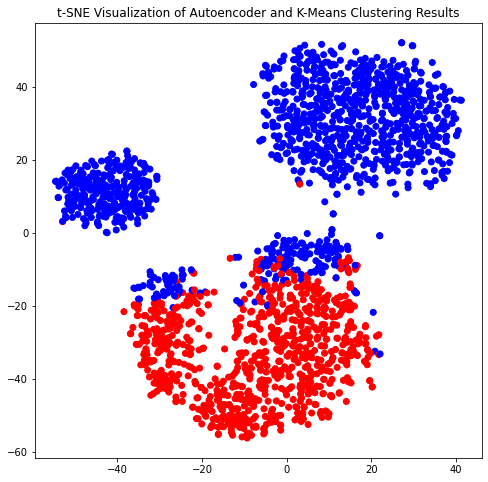

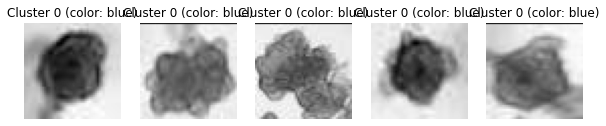

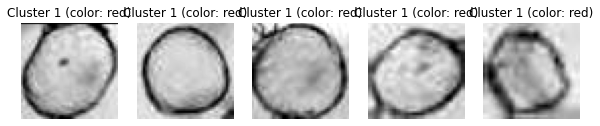

In [58]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import SpectralClustering



codes_train = encoder.predict(X_train)




kmeans = KMeans(n_clusters=2)
clusters = kmeans.fit_predict(codes_train)


tsne = TSNE(n_components=2)
codes_2d = tsne.fit_transform(codes_train)


colors = ['blue', 'red']


point_colors = [colors[cluster] for cluster in clusters]


plt.figure(figsize=(8, 8))
plt.scatter(codes_2d[:, 0], codes_2d[:, 1], c=point_colors)
plt.title('t-SNE Visualization of Autoencoder and K-Means Clustering Results')
plt.show()


n_clusters = 2  
n_images = 5  

n_columns = 5
n_rows =1
for i in range(n_clusters):
    cluster_indices = np.where(clusters == i)[0]
    selected_indices = np.random.choice(cluster_indices, n_images)

    plt.figure(figsize=(n_columns * 2, n_rows * 2))
    for j, image_index in enumerate(selected_indices):
        image = X_train[image_index]
        plt.subplot(n_rows, n_columns, j + 1)
        plt.imshow(image, cmap='gray') 
        plt.axis('off')
        plt.title('Cluster {} (color: {})'.format(i, colors[i]))

    plt.show()


65/65 [==============================] - 2s 31ms/step


/home/jupyter-qil420/.local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/jupyter-qil420/.local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


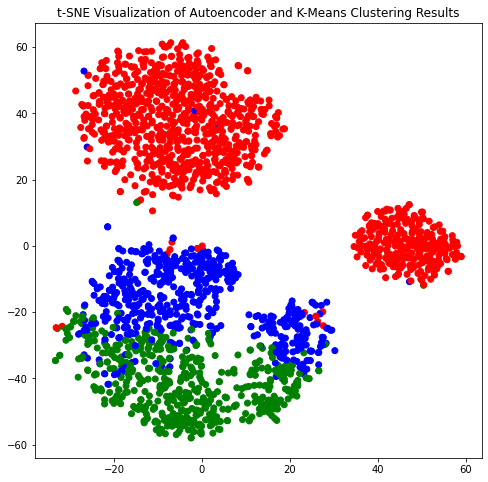

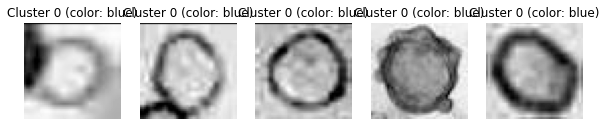

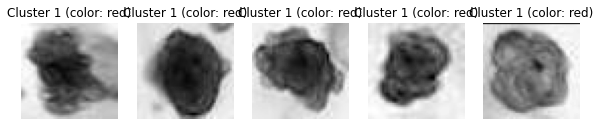

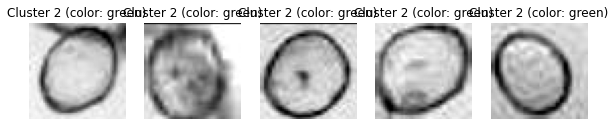

In [60]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import SpectralClustering



codes_train = encoder.predict(X_train)




kmeans = KMeans(n_clusters=3)
clusters = kmeans.fit_predict(codes_train)


tsne = TSNE(n_components=2)
codes_2d = tsne.fit_transform(codes_train)


colors = ['blue', 'red', 'green']


point_colors = [colors[cluster] for cluster in clusters]


plt.figure(figsize=(8, 8))
plt.scatter(codes_2d[:, 0], codes_2d[:, 1], c=point_colors)
plt.title('t-SNE Visualization of Autoencoder and K-Means Clustering Results')
plt.show()


n_clusters = 3  
n_images = 5  

n_columns = 5
n_rows =1
for i in range(n_clusters):
    cluster_indices = np.where(clusters == i)[0]
    selected_indices = np.random.choice(cluster_indices, n_images)

    plt.figure(figsize=(n_columns * 2, n_rows * 2))
    for j, image_index in enumerate(selected_indices):
        image = X_train[image_index]
        plt.subplot(n_rows, n_columns, j + 1)
        plt.imshow(image, cmap='gray') 
        plt.axis('off')
        plt.title('Cluster {} (color: {})'.format(i, colors[i]))

    plt.show()


In [11]:
def build_conv_autoencoder(img_shape, code_size):
    # Encoder
    encoder = keras.models.Sequential()
    encoder.add(L.InputLayer(img_shape))
    encoder.add(L.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu')) 
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    encoder.add(L.Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    encoder.add(L.Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))  
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    encoder.add(L.Flatten())
    encoder.add(L.Dense(code_size))  
    print(encoder.layers[-3].output_shape)
    # Decoder
    decoder = keras.models.Sequential()
    decoder.add(L.InputLayer((code_size,)))
    decoder.add(L.Dense(90 * 90 * 128)) 
    decoder.add(L.Reshape((90, 90, 128)))
    print(encoder.layers[-3].output_shape)
    decoder.add(L.Conv2DTranspose(128, kernel_size=(3, 3), padding='same', activation='relu'))
    decoder.add(L.UpSampling2D((2, 2)))
    decoder.add(L.Conv2DTranspose(64, kernel_size=(3, 3), padding='same', activation='relu'))
    decoder.add(L.UpSampling2D((2, 2)))
    decoder.add(L.Conv2DTranspose(32, kernel_size=(3, 3), padding='same', activation='relu'))
    decoder.add(L.UpSampling2D((2, 2)))
    decoder.add(L.Conv2DTranspose(img_shape[-1], kernel_size=(3, 3), padding='same')) 

    return encoder, decoder
